In [1]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Image
from ipywidgets import interact,Dropdown,IntSlider,FloatRangeSlider, FloatSlider, RadioButtons
rc('animation', html='html5')
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os,sys
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/xupeng/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
cd /home/xupeng/projects/synapse

/home/xupeng/projects/synapse


In [3]:
sys.path.append('bin/synapse_pytorch')

In [4]:
import pickle, h5py, time, argparse, itertools, datetime

import torch
import torch.nn as nn
import torch.utils.data
from libs import SynapseDataset, collate_fn, WeightedBCELoss, res_unet
from tensorboardX import SummaryWriter

In [27]:
def get_args():
    parser = argparse.ArgumentParser(description='Training Synapse Detection Model')
    # I/O
    parser.add_argument('-t','--train',  default='data/cremi/',
                        help='Input folder (train)')
    # parser.add_argument('-v','--val',  default='',
    #                     help='input folder (test)')
    parser.add_argument('-dn','--img-name',  default='images/im_A_v2_200.h5',
                        help='Image data path')
    parser.add_argument('-ln','--seg-name',  default='gt-syn/syn_A_v2_200.h5',
                        help='Ground-truth label path')
    parser.add_argument('-o','--output', default='result/train/',
                        help='Output path')
    parser.add_argument('-mi','--model-input', type=str,  default='24,256,256',
                        help='I/O size of deep network')
    parser.add_argument('-ft','--finetune', default=False,
                        help='Fine-tune on previous model [Default: False]')
    parser.add_argument('-pm','--pre-model', type=str, default='',
                        help='Pre-trained model path')                  

    # optimization option
    parser.add_argument('-lr', type=float, default=0.0001,
                        help='Learning rate')
    # parser.add_argument('-lr_decay', default='inv,0.0001,0.75',
    #                     help='learning rate decay')
    # parser.add_argument('-betas', default='0.99,0.999',
    #                     help='beta for adam')
    # parser.add_argument('-wd', type=float, default=5e-6,
    #                     help='weight decay')
    parser.add_argument('--volume-total', type=int, default=1000,
                        help='Total number of iteration')
    parser.add_argument('--volume-save', type=int, default=100,
                        help='Number of iteration to save')
    parser.add_argument('-g','--num-gpu', type=int,  default=1,
                        help='Number of gpu')
    parser.add_argument('-c','--num-cpu', type=int,  default=1,
                        help='Number of cpu')
    parser.add_argument('-b','--batch-size', type=int,  default=1,
                        help='Batch size')
    args = parser.parse_args()
    return args

def init(args):
    sn = args.output+'/'
    if not os.path.isdir(sn):
        os.makedirs(sn)
    # I/O size in (z,y,x), no specified channel number
    model_io_size = np.array([int(x) for x in args.model_input.split(',')])

    # select training machine
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    return model_io_size, device

def get_input(args, model_io_size, opt='train'):
    # two dataLoader, can't be both multiple-cpu (pytorch issue)

    if opt=='train':
        dir_name = args.train.split('@')
        num_worker = args.num_cpu
        img_name = args.img_name.split('@')
        seg_name = args.seg_name.split('@')
    else:
        dir_name = args.val.split('@')
        num_worker = 1
        img_name = args.img_name_val.split('@')
        seg_name = args.seg_name_val.split('@')

    # may use datasets from multiple folders
    # should be either one or the same as dir_name
    seg_name = [dir_name[0] + x for x in seg_name]
    img_name = [dir_name[0] + x for x in img_name]
    # print(img_name)
    # print(seg_name)
    
    # 1. load data
    train_input = [None]*len(img_name)
    train_label = [None]*len(seg_name)
    assert len(img_name)==len(seg_name)

    # original image is in [0, 255], normalize to [0, 1]
    for i in range(len(img_name)):
        train_input[i] = np.array(h5py.File(img_name[i], 'r')['main'])[14:-14, 200:-200, 200:-200]/255.0
        train_label[i] = np.array(h5py.File(seg_name[i], 'r')['main'])[14:-14, 200:-200, 200:-200]
        train_label[i] = (train_label[i] != 0).astype(float)
        assert train_input[i].shape==train_label[i].shape
        print("volume shape: ", train_input[i].shape)    

    dataset = SynapseDataset(volume=train_input, label=train_label, vol_input_size=model_io_size, \
                                 vol_label_size=model_io_size, data_aug=None) # no data augmentation
    # to have evaluation during training (two dataloader), has to set num_worker=0
    SHUFFLE = (opt=='train')
    img_loader =  torch.utils.data.DataLoader(
            dataset, batch_size=args.batch_size, shuffle=SHUFFLE, collate_fn = collate_fn,
            num_workers=args.num_cpu, pin_memory=True)
    return img_loader

def get_logger(args):
    log_name = args.output+'/log'
    date = str(datetime.datetime.now()).split(' ')[0]
    time = str(datetime.datetime.now()).split(' ')[1].split('.')[0]
    log_name += '_approx_'+date+'_'+time
    logger = open(log_name+'.txt','w') # unbuffered, write instantly

    # tensorboardX
    writer = SummaryWriter('runs/'+log_name)
    return logger, writer

def train(args, train_loader, model, device, criterion, optimizer, logger, writer):
    # switch to train mode
    model.train()
    volume_id = 0

    for i, (volume, label, class_weight, weight_factor) in enumerate(train_loader):
        volume_id += args.batch_size

        print(volume.size())
        print(label.size())
        # for gpu computing
        print(weight_factor)
        volume, label = volume.to(device), label.to(device)
        class_weight = class_weight.to(device)
        output = model(volume)
        loss = criterion(output, label, class_weight)

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logger.write("[Volume %d] train_loss=%0.4f lr=%.5f" % (volume_id, \
                loss.item(), optimizer.param_groups[0]['lr']))
        writer.add_scalar('train_loss', loss.item(), volume_id)

        # LR update
        #if args.lr > 0:
            #decay_lr(optimizer, args.lr, volume_id, lr_decay[0], lr_decay[1], lr_decay[2])
        
        if volume_id % args.volume_save < args.batch_size or volume_id >= args.volume_total:
            torch.save(model.state_dict(), args.output+('/volume_%d.pth' % (volume_id)))
        # Terminate
        if volume_id >= args.volume_total:
            break    #     

def main():
    args = get_args()

    print('0. initial setup')
    model_io_size, device = init(args) 
    logger, writer = get_logger(args)

    print('1. setup data')
    train_loader = get_input(args, model_io_size, 'train')

    print('2. setup model')
    model = res_unet()
    if args.finetune == True:
        model.load_state_dict(torch.load(args.pre_model))
        print('fine-tune on previous model')
            
    if args.num_gpu>1: model = nn.DataParallel(model, range(args.num_gpu))
    model = model.to(device)
    criterion = WeightedBCELoss()

    print('3. setup optimizer')
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999))

    print('4. start training')
    train(args, train_loader, model, device, criterion, optimizer, logger, writer)
  
    print('5. finish training')
    logger.close()
    writer.close()

In [28]:
args = get_args()
model_io_size, device = init(args) 

In [29]:
print (model_io_size)
print (device)

[ 24 256 256]
cuda


In [30]:
logger, writer = get_logger(args)

In [31]:
#train_loader = get_input(args, model_io_size, 'train')

In [32]:
#train_loader

In [33]:
model = res_unet()
#if args.finetune == True:
#need pretrained model!
#model.load_state_dict(torch.load(args.pre_model))

In [34]:
args.num_gpu

1

In [35]:
#if args.num_gpu>1: 
model = nn.DataParallel(model, range(args.num_gpu))

In [36]:
model = model.to(device)
criterion = WeightedBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999))

In [37]:
torch.backends.cudnn.benchmark = True

In [38]:
from torchsummary import summary
summary(model, input_size=(1,4, 256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 4, 256, 256]             288
       BatchNorm3d-2      [-1, 32, 4, 256, 256]              64
              ReLU-3      [-1, 32, 4, 256, 256]               0
            Conv3d-4      [-1, 32, 4, 256, 256]           9,216
       BatchNorm3d-5      [-1, 32, 4, 256, 256]              64
              ReLU-6      [-1, 32, 4, 256, 256]               0
            Conv3d-7      [-1, 32, 4, 256, 256]           9,216
       BatchNorm3d-8      [-1, 32, 4, 256, 256]              64
              ReLU-9      [-1, 32, 4, 256, 256]               0
res_unet_AnisoBlock-10      [-1, 32, 4, 256, 256]               0
        MaxPool3d-11      [-1, 32, 4, 128, 128]               0
           Conv3d-12      [-1, 64, 4, 128, 128]          18,432
      BatchNorm3d-13      [-1, 64, 4, 128, 128]             128
             ReLU-14      [-1, 64, 4,

In [42]:
from torchviz import make_dot

x = Variable(torch.randn(1,1,24, 256,256))#change 12 to the channel number of network input
y = model(x)
g = make_dot(y)
g.view()

'Digraph.gv.pdf'

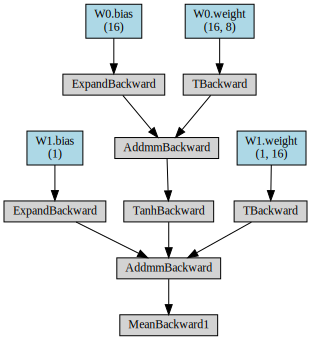

In [26]:
from torch.autograd import Variable
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = Variable(torch.randn(1,8))
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters()))